# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Predicting The Future (ARIMA 2)
---
### LEARNING OBJECTIVES
*After this lesson, students will be able to:*
- Create ARIMA models using statsmodels
- Evaluate ARIMA models
- Use ARIMA models to make predictions


In our previous lesson, we went over the basics of AR, MA, and ARIMA models. We discussed what stationarity is, why it is important, we went through an example workflow for constructing and ARIMA model based on timeseries data, and then did basically the first half of this codelong (visualizing and detrending the timeseries data).

For reference, this is the workflow we followed:

![](workflow.png)


We'll discuss these steps as we implement them using the code from our previous lecture:

### 1. Visualize the timeseries
---
This step is very similar to what we would do with any other data problem. 

**Check**: What kind of information might we get by visualizing data (in any situation, not just timeseries analysis)?.

With timeseries analysis, we're going to want to figure out what the trends over time are, and looking at it visually helps us find those trends. We can see whether our values seem to be increasing or decreasing overtime, or whether there are some seasonal effects.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('portland-oregon-average-monthly-original.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

In [3]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [4]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)
df

,riders
1973-01-01,64800
1973-02-01,64600
1973-03-01,63900
1973-04-01,65400
1973-05-01,63000
1973-06-01,62200
1973-07-01,61700
1973-08-01,61300
1973-09-01,66100
1973-10-01,69500


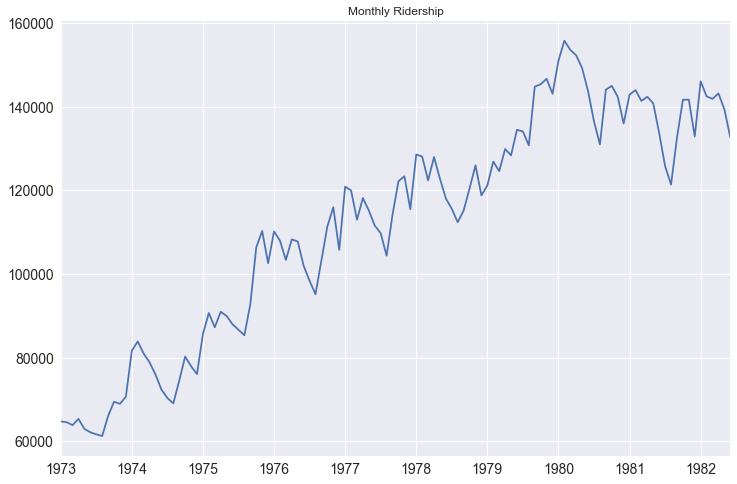

In [5]:
df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
#plt.savefig('month_ridership.png', bbox_inches='tight')

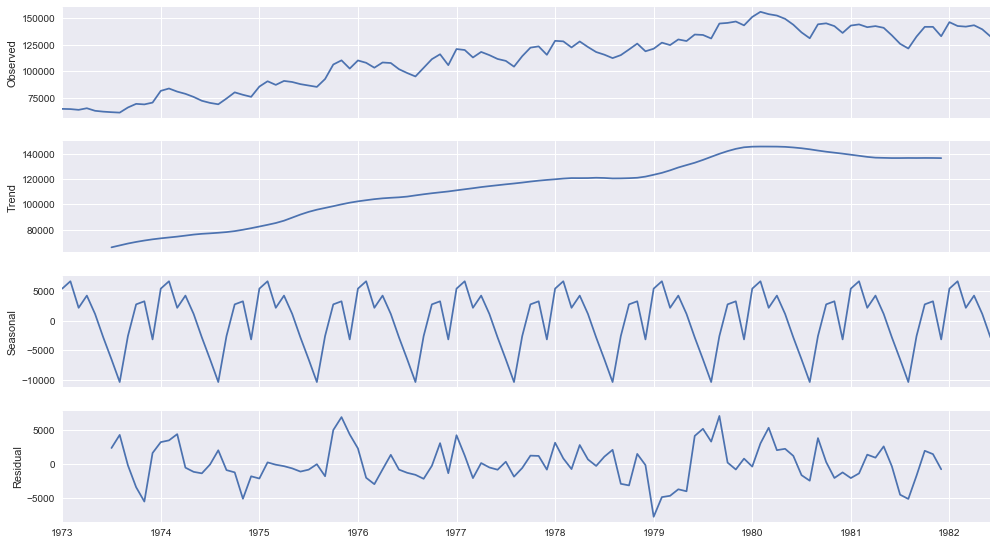

In [6]:
decomposition = seasonal_decompose(df.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

From these trends, we can identify two trends: a general upwards trend, and a seasonal (cyclical) trend. This tells us that to stationize this data, we'll have to account for both the difference and the season difference. Our season will be comprised of twelve observations, since this is monthly data and we can see that every cycle seems to more or less happen over twelve months. This also makes intuitive sense, since twelve months is one year.

While we have an intuitive understanding of what trends we have to eliminate in order to stationize, we are going to want a more empirical method of evaluating whether we've achieved stationarity. One way we can do this is using the **Dickey-Fuller test**.

High-level explanation of Dickey Fuller: Dickey-Fuller is essentially a hypothesis test of whether or not our data is stationary. The null hypothesis is that it is not stationary, the alternative hypothesis is that it is stationary. If we reject our null-hypothesis, then we are saying that our timeseries is already stationary and does not need to be differenced. If we fail to reject it, then our timeseries is _not_ stationary, and does need to be differenced.

Slightly more mathematical explanation:
Our model is non-stationary or a unit root is present if $\rho = 1$.

$$y_t = \rho y_{t-1} + \epsilon_t$$                             
$$\downarrow$$                                                
$$y_t - y_{t-1} = \rho y_{t-1}-y_{t-1} + \epsilon_t$$             
$$\downarrow$$                                              
$$\Delta y_t = (\rho - 1)y_{t-1} + \epsilon_t = \gamma y_{t-1} + \epsilon_t$$

We have to go through these steps because under the null hypothesis, our data is not stationary and therefore we cannot use a hypothesis test because the central limit theorem does not apply to non-stationary data.

Our null hypothesis ($H_0$) is $\rho = 1$ so $\gamma = 0$             
Our alternative hypothesis ($H_A$) is $\rho < 1$ so $\gamma < 0$


**NOTE**: While this is a hypothesis test, we do not expect values to be probabilities and we do not have the same values that we would for a t-test. Instead, the way we evaluate the test statistic from this test is by seeing whether it falls to the left of (is less than) our critical value.

High level explanation of [unit root](http://www.statisticshowto.com/unit-root/)
[Youtube video](https://www.youtube.com/watch?v=2GxWgIumPTA) explaining Dickey-Fuller Test

### 2. Stationize

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


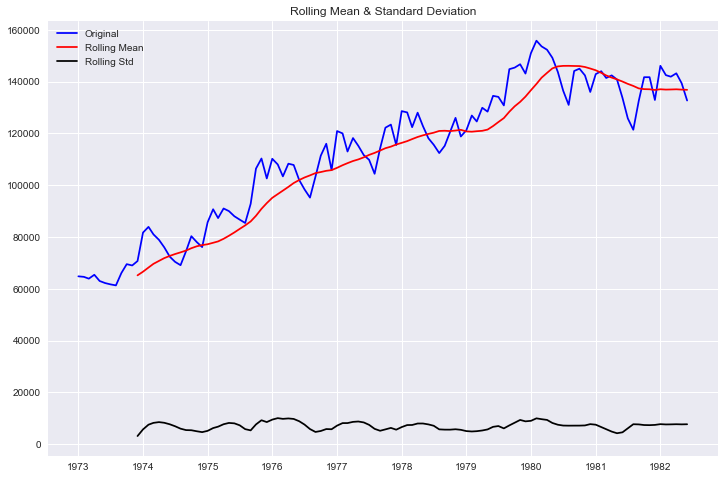

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [8]:
test_stationarity(df.riders)

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


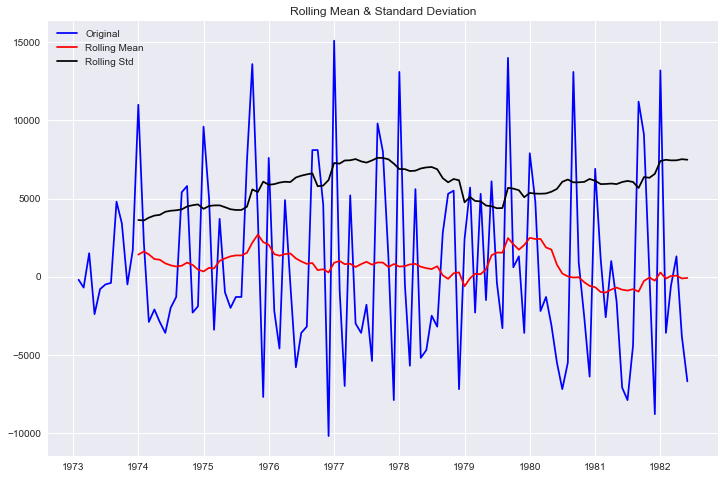

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [9]:
df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


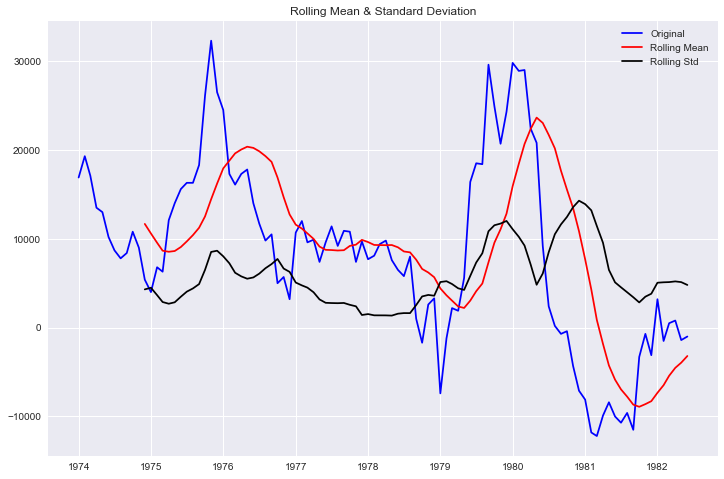

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (5%)            -2.891516
Critical Value (1%)            -3.498910
Critical Value (10%)           -2.582760
dtype: float64


In [10]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


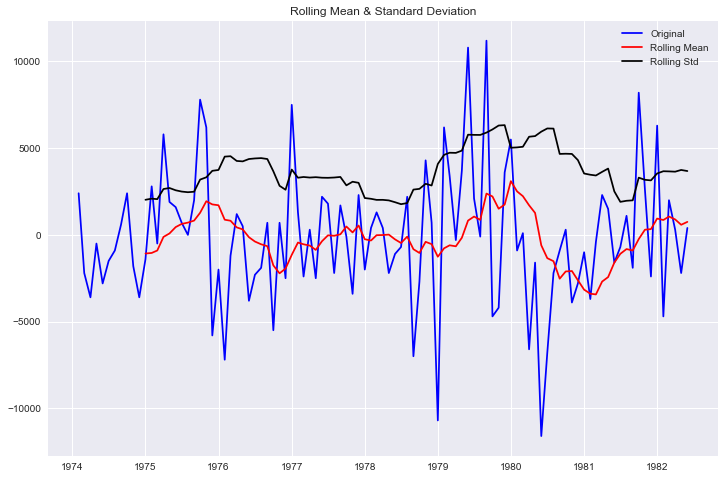

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (5%)           -2.890906e+00
Critical Value (1%)           -3.497501e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [11]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

**Check**: Why do we care about stationarity?

### 3. Plot ACF and PACF to Seek Optimal Parameters

Below we have an ACF and a PACF of our timeseries without the differences

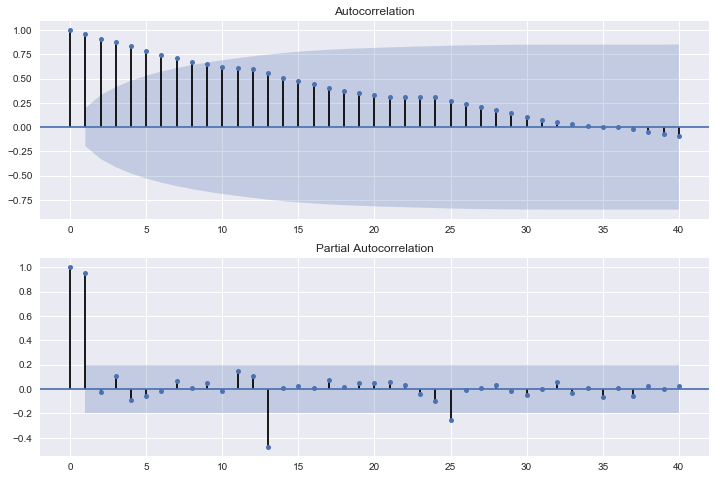

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.riders.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.riders.iloc[13:], lags=40, ax=ax2)

What are these graphs showing us?

ACF is pretty simple, it is just the correlation between values with values of a certain lag:

$$ACF(k) = \frac{Cov(y_t,y_{t-k})}{Var(y_k)}$$

PACF is a little more complicated. It measures the correlation between $y_t$ and $y_{t-k}$ minus the information explained by intervening lags:

$$PACF(k) = Corr[y_t - E^*(y_t|y_{t-1},...,y_{t-k+1},y_{t-k})]$$

Where $E^*$ is the minimum mean squared error predictor of $y_t$ by $y_{t-1},...,y_{t-k+1}$.

### General Rules for Selecting Parameters based on ACF and PACF:
---
#### Identifying the order of differencing and the constant:


**Rule 1**: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.                           
**Rule 2**: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.                         
**Rule 3**: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)                           
**Rule 4**: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).                 
**Rule 5**: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.
                                                
#### Identifying the numbers of AR and MA terms:

**Rule 6**: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.         
**Rule 7**: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.                   
**Rule 8**: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.                                         
**Rule 9**: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.            
**Rule 10**: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.       
**Rule 11**: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.                                                   
                                                                                   
#### Identifying the seasonal part of the model:

**Rule 12**: If the series has a strong and consistent seasonal pattern, then you must use an order of seasonal differencing (otherwise the model assumes that the seasonal pattern will fade away over time). However, never use more than one order of seasonal differencing or more than 2 orders of total differencing (seasonal+nonseasonal).      
**Rule 13**: If the autocorrelation of the appropriately differenced series is positive at lag s, where s is the number of periods in a season, then consider adding an SAR term to the model. If the autocorrelation of the differenced series is negative at lag s, consider adding an SMA term to the model. The latter situation is likely to occur if a seasonal difference has been used, which should be done if the data has a stable and logical seasonal pattern. The former is likely to occur if a seasonal difference has not been used, which would only be appropriate if the seasonal pattern is not stable over time. You should try to avoid using more than one or two seasonal parameters (SAR+SMA) in the same model, as this is likely to lead to overfitting of the data and/or problems in estimation.

Source: [Duke Material](http://people.duke.edu/~rnau/arimrule.htm)

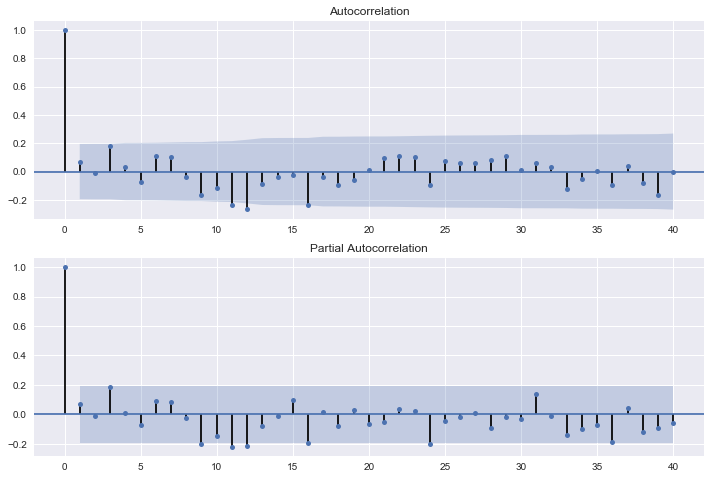

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

### 4. Build the ARIMA Model
---
While we use the ACF and PACF graphs to decide on parameters, these visualizations may serve only as starting points. Often the graphs can be hard to interpret, and we may want to try out different values for parameters in order to find the best model.

In [14]:
mod = sm.tsa.statespace.SARIMAX(df.riders.iloc[:101], trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  101
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -851.685
Date:                            Thu, 17 Aug 2017   AIC                           1707.370
Time:                                    11:29:14   BIC                           1712.600
Sample:                                01-01-1973   HQIC                          1709.487
                                     - 05-01-1981                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1654      0.045     -3.713      0.000      -0.253      -0.078
sigma2      1.266e+07   1.38e+06      9.146      0.000    9.95e+06    1.54e+07
===================================================================================
Ljung-Box (Q):                       37.00   Jarque-Bera (JB):                 3.43
Prob(Q):                              0.61   Prob(JB):                         0.18
Heteroskedasticity (H):               1.81   Skew:                             0.12
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
mod = sm.tsa.statespace.SARIMAX(df.riders.iloc[:101], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  101
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -847.072
Date:                            Thu, 17 Aug 2017   AIC                           1700.143
Time:                                    11:29:14   BIC                           1707.989
Sample:                                01-01-1973   HQIC                          1703.319
                                     - 05-01-1981                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5749      0.105      5.488      0.000       0.370       0.780
ma.S.L12      -0.9565      0.163     -5.877      0.000      -1.275      -0.637
sigma2      1.266e+07   1.71e-08   7.38e+14      0.000    1.27e+07    1.27e+07
===================================================================================
Ljung-Box (Q):                       38.58   Jarque-Bera (JB):                 8.18
Prob(Q):                              0.53   Prob(JB):                         0.02
Heteroskedasticity (H):               1.89   Skew:                             0.28
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.15e+29. Standard errors may be unstable.
"""

#### Evaluating our Model
---
There are many different evaluation metrics we can use to assess our models. A common metric is AIC, which is displayed in the statsmodels summary table.

AIC stands for Akaike Information Criterion. It rewards how well our model fits our data and penalizes our model for how many parameters it has. The AIC value itself is meaningless, it only lets us compare one model to another in order to decide which one is better.

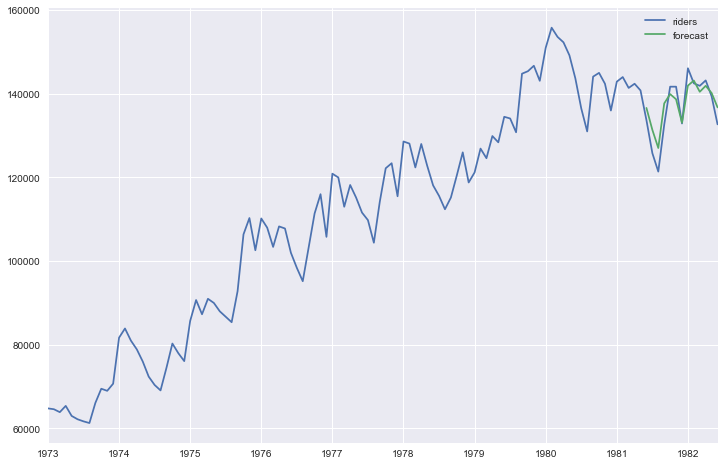

In [16]:
df['forecast'] = results.predict(start = 101, end= 114, dynamic=True)
#df.riders.iloc[:102].plot()
#df.forecast.plot(figsize=(12,8))
df[['riders', 'forecast']].plot(figsize=(12, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


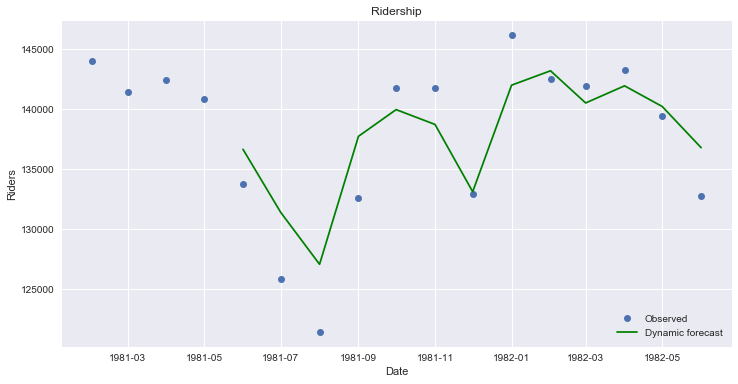

In [17]:
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
#plt.savefig('ts_predict_compare.png', bbox_inches='tight')

In [18]:
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

### 5. Predict the Future

/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


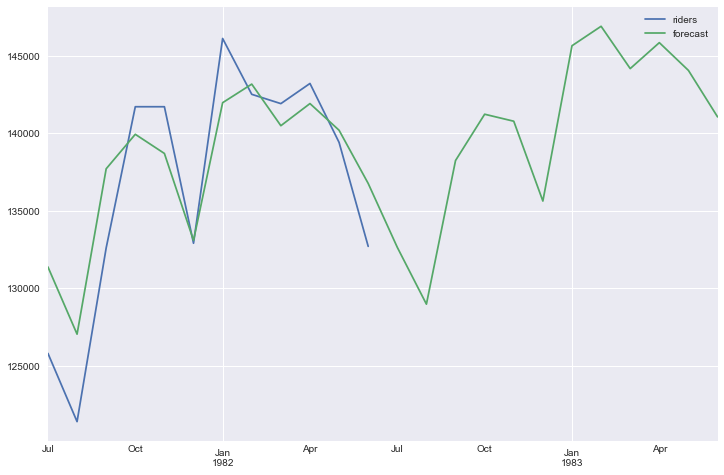

In [19]:
df['forecast'] = results.predict(start = 101, end = 125, dynamic=True)  
df[['riders', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 
# plt.savefig('ts_predict_future.png', bbox_inches='tight')

### 6. Profit...